In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder
import scipy
import itertools
from sklearn.feature_extraction.text import CountVectorizer
import unicodedata, re, string
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer


## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_5.csv')

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

1700    curious know dog really found anything husband...
734     sun fallen almost level cliff slanting upward ...
937     man learn ride fashion day yet year fashions h...
185     bed summer ii thought iii sea-side iv young ni...
699     mack nolan crawled bunk wednesday night though...
1771    sure paddy warned going promised soon pond big...
1350    father saying ah pleasant place wonder lives l...
638     's met misfortune 's use concealing answered d...
21      father fergus tenth direct descent john tower ...
1146    titmarsh boy said one day looking hard face ev...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

# CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
X_train_cv = vectorizer.fit_transform(X_train).toarray()
X_test_cv = vectorizer.transform(X_test).toarray()
X_valid_cv = vectorizer.transform(X_valid).toarray()


In [ ]:
y_train.shape

(1267, 81)

## Model 2

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_cv.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               81247232  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train_cv, y_train, validation_data=(X_valid_cv, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
159/159 [==============================] - 11s 43ms/step - loss: 4.5358 - accuracy: 0.1081 - val_loss: 3.3345 - val_accuracy: 0.3688
Epoch 2/10
159/159 [==============================] - 7s 44ms/step - loss: 3.5095 - accuracy: 0.2628 - val_loss: 3.1315 - val_accuracy: 0.3546
Epoch 3/10
159/159 [==============================] - 7s 47ms/step - loss: 3.0178 - accuracy: 0.3520 - val_loss: 2.5539 - val_accuracy: 0.5319
Epoch 4/10
159/159 [==============================] - 6s 40ms/step - loss: 2.6911 - accuracy: 0.4049 - val_loss: 2.2253 - val_accuracy: 0.5319
Epoch 5/10
159/159 [==============================] - 6s 40ms/step - loss: 2.3696 - accuracy: 0.4807 - val_loss: 1.9218 - val_accuracy: 0.5674
Epoch 6/10
159/159 [==============================] - 4s 26ms/step - loss: 2.0060 - accuracy: 0.5525 - val_loss: 2.1341 - val_accuracy: 0.5816
Epoch 7/10
159/159 [==============================] - 4s 26ms/step - loss: 1.8247 - accuracy: 0.5817 - val_loss: 2.0062 - val_accuracy: 0.602

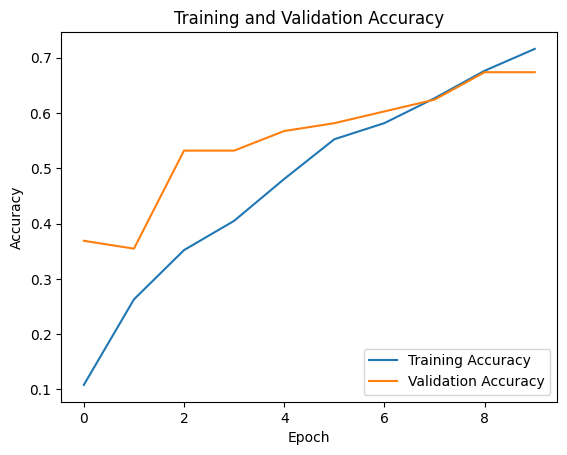

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_cv, y_test, verbose=0)

y_pred_probs = model.predict(X_test_cv)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

test_f1 = f1_score(y_test_indices, y_pred, average='macro')
test_precision = precision_score(y_test_indices, y_pred, average='macro')
test_recall = recall_score(y_test_indices, y_pred, average='macro')

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

11/11 [==============================] - 0s 14ms/step
Test loss: 1.4546618461608887
Test accuracy: 0.6875
Test F1 Score: 0.4330861501527136
Test Precision: 0.4602979987848408
Test Recall: 0.4791688974758878


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TextVectorization

## Model 3


In [ ]:
embedding_dim = 512
vocab_size = 100000
sequence_length = 11000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 11000)             0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 11000, 512)        51200000  
                                                                 
 global_average_pooling1d (  (None, 512)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
159/159 [==============================] - 24s 134ms/step - loss: 4.0835 - accuracy: 0.0734 - val_loss: 3.6222 - val_accuracy: 0.1489
Epoch 2/15
159/159 [==============================] - 20s 127ms/step - loss: 3.5086 - accuracy: 0.1468 - val_loss: 2.9685 - val_accuracy: 0.2553
Epoch 3/15
159/159 [==============================] - 20s 126ms/step - loss: 2.8627 - accuracy: 0.2502 - val_loss: 2.4603 - val_accuracy: 0.3688
Epoch 4/15
159/159 [==============================] - 20s 125ms/step - loss: 2.2948 - accuracy: 0.3781 - val_loss: 2.2203 - val_accuracy: 0.4681
Epoch 5/15
159/159 [==============================] - 20s 123ms/step - loss: 1.7254 - accuracy: 0.4996 - val_loss: 1.9202 - val_accuracy: 0.5319
Epoch 6/15
159/159 [==============================] - 19s 121ms/step - loss: 1.3138 - accuracy: 0.6148 - val_loss: 1.6547 - val_accuracy: 0.5887
Epoch 7/15
159/159 [==============================] - 17s 106ms/step - loss: 0.9889 - accuracy: 0.7040 - val_loss: 1.7972 - val_ac

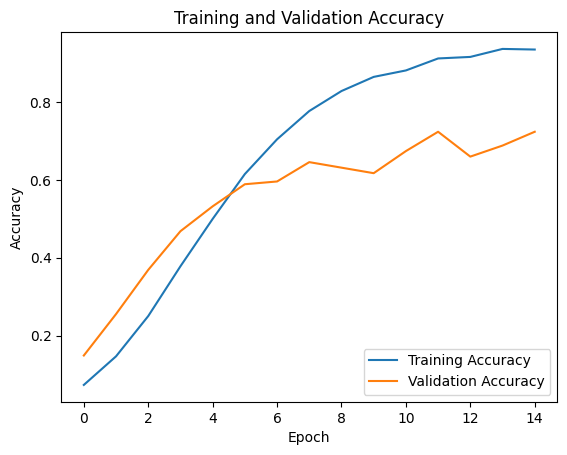

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

11/11 [==============================] - 1s 68ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted')
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.7017045454545454
F1 Score: 0.7071014076695895
Precision: 0.7655422702297702
Recall: 0.7017045454545454


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
